In [1]:
import numpy as np 
from scipy.integrate import solve_ivp
import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
from kernel_sca import *
from utils import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import wandb
from itertools import combinations

In [2]:
#Create X ( K = initial condition, N = (x1,x2), T = len(t_eval) )

num_trajectories = 40
time_steps = 50

time = jnp.linspace(0, 4 *jnp.pi, time_steps)[:, jnp.newaxis]
radii = jnp.linspace(0.1, 2, num_trajectories)
phases = jnp.linspace(0, 2*jnp.pi, num_trajectories)

X = time + phases 
sine_waves = jnp.sin(X) * radii
cosine_waves = jnp.cos(X) * radii
X = jnp.stack([cosine_waves.T, sine_waves.T], axis=1)   #K=50, N=2, T=200

print(np.mean(compute_S(X)))
print(compute_S_all_pairs(X))
# plt.figure(figsize=(4,4))
# plt.plot(sine_waves[:,10])
# plt.plot(cosine_waves[:,10])


0.97116894
0.9828347


0.0021924332


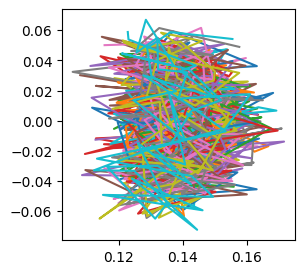

In [3]:

## 
seed = 42


D = 50 #=N'
l = 5
mean = jnp.array([0.0, 0.0])  
covariance = jnp.array([[(1/l**2), 0.0], [0.0, (1/l**2)]])

key = random.PRNGKey(seed)
key, subkey = random.split(key)
samples_omega = random.multivariate_normal(key, mean, covariance, shape=(D,)) #(N',N) 

dot_prod = jnp.einsum('lj,ijk->ilk', samples_omega, X)                                  #(K, N', T)
K, _, T = dot_prod.shape

cos_values = jnp.cos(dot_prod)
sin_values = jnp.sin(dot_prod)

phi = jnp.hstack((cos_values, sin_values))  * (1 / jnp.sqrt(D))                           #(K, 2*N', T)                                     #(K, 2*N', T)

noise = random.normal(subkey, (phi.shape)) 
phi += 0.01 * (noise) 

plt.figure(figsize=(3,3))
for i in range(num_trajectories):
    plt.plot(phi[i,2,:], phi[i,52,:] )

print( compute_S_all_pairs(phi) )

# # for i in range(5):
# plt.figure()
# plt.plot(phi[0,15,:] )
# #plt.plot(phi[0,65,:] )

# cov = np.cov( np.concatenate(phi.swapaxes(1,2)) )
# print(phi.shape)
# print(np.concatenate(phi.swapaxes(1,2)).shape)
# plt.imshow(np.cov( np.concatenate(phi.swapaxes(1,2)) ))

In [4]:
split = 15

X_train = phi[split:]
print( compute_S_all_pairs(X_train) )
X_test = phi[:split]
K, N, T = X_train.shape

A = jnp.swapaxes(X_train, 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                              #(N, K*T)

K_A_X = K_X_Y_identity(A, X_train)               #(K*T, K, T)
K_A_A = K_X_Y_identity(A, A)

# K_A_X = np.zeros((K*T, K, T))
# for k in range(K):
#     K_A_X[:,k,:] = K_X_Y_squared_exponential(A, X_train[k], l = l)
# K_A_X = jnp.array(K_A_X)
# K_A_A = jnp.array(K_X_Y_squared_exponential(A, A, l = l))

K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
P, S, Pt = jnp.linalg.svd(K_A_A_tilde, full_matrices=False)      #P is (K*T, K*T) and S is (K*T,)

#plt.imshow(K_A_A)

0.016106665


In [5]:
d=2
wandb.init(project="SCA-project-toydata-kernel", name="run_1", mode="disabled")
alpha_tilde, ls_loss, ls_S_ratio = optimize(P, S, K_A_X, X_train, d=d, learning_rate=0.01, iterations=1000) 
wandb.finish
np.save('alpha_tilde', alpha_tilde)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Iteration 0, S: 3.5524021768651437e-06, S_ratio: 0.7116971015930176
Iteration 10, S: 5.522826995729702e-06, S_ratio: 0.6757766604423523
Iteration 20, S: 1.0317322448827326e-05, S_ratio: 0.6441648602485657
Iteration 30, S: 1.7066722648451105e-05, S_ratio: 0.8860217332839966
Iteration 40, S: 3.496558565529995e-05, S_ratio: 0.7636250257492065
Iteration 50, S: 7.605012797284871e-05, S_ratio: 0.7954176664352417
Iteration 60, S: 0.00019635242642834783, S_ratio: 0.7759600877761841
Iteration 70, S: 0.000576048856601119, S_ratio: 0.8218225240707397
Iteration 80, S: 0.0016167021822184324, S_ratio: 0.7360261678695679
Iteration 90, S: 0.0063730403780937195, S_ratio: 0.9189286828041077
Iteration 100, S: 0.016944561153650284, S_ratio: 0.8875073194503784
Iteration 110, S: 0.04547492042183876, S_ratio: 0.7988649606704712
Iteration 120, S: 0.09257079660892487, S_ratio: 0.9743523597717285
Iteration 130, S: 0.14661374688148499, S_ratio: 0.7508060336112976
Iteration 140, S: 0.16971851885318756, S_ratio: 0

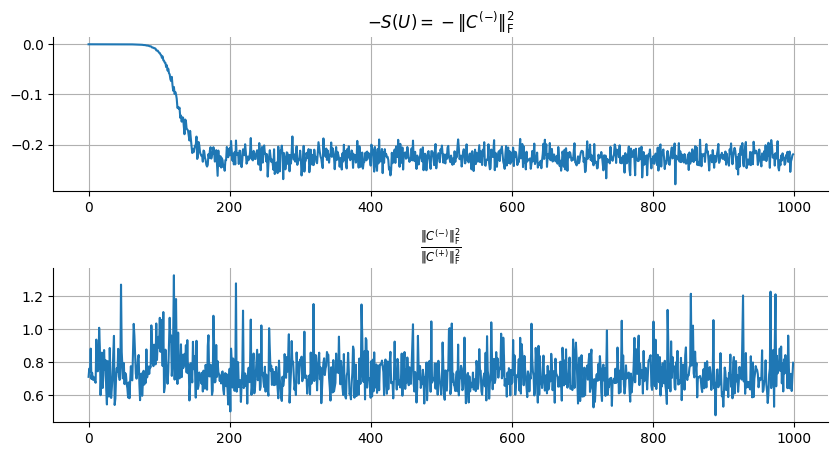

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(ls_loss)
plt.grid()
plt.title(r"$-S(U) = -\|C^{(-)}\|_\mathrm{F}^2$")
plt.gca().spines[['top','right']].set_visible(False)
plt.subplot(212)
plt.plot(ls_S_ratio)
plt.title(r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$")
plt.gca().spines[['top','right']].set_visible(False)
plt.grid()
plt.subplots_adjust(hspace=0.5)

Text(0.5, 1.0, 's = 0.5166006684303284')

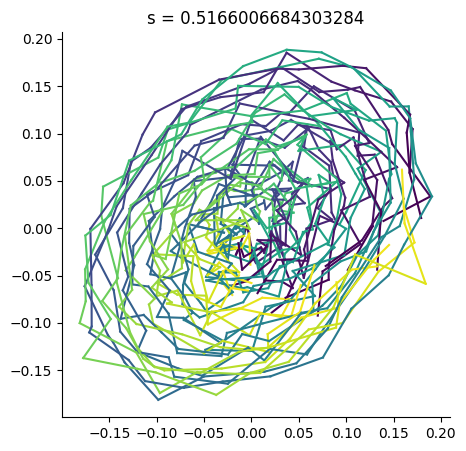

In [10]:
alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
alpha = (P / jnp.sqrt(S)) @ alpha_tilde_QR

alpha_reshaped = alpha.reshape(K,T,d)                                           #(K, T, d)
mean = jnp.mean(alpha_reshaped, axis=(0), keepdims=True)                        #(1, T, d)
alpha_H = (alpha_reshaped - mean).reshape(K*T,d)                      #(K*T,d)

# K_test, _, _ = X_test.shape
# K_A_X_test = np.zeros((K*T, K_test, T))
# for k in range(K_test):
#     K_A_X_test[:,k,:] = K_X_Y_squared_exponential(A, X_test[k], l = l)
# K_A_X_test = jnp.array(K_A_X_test)

K_A_X_test = K_X_Y_identity(A, X_test)                                     #(K*T, K, T)

projection = jnp.einsum('ij,imk->mjk', alpha_H, K_A_X_test[:,:,:])                #(K*T,d) @ (K*T, K, T) --> (K, d, T)


plot_2D(projection)
plt.title(f"s = {compute_S_all_pairs(projection)}")

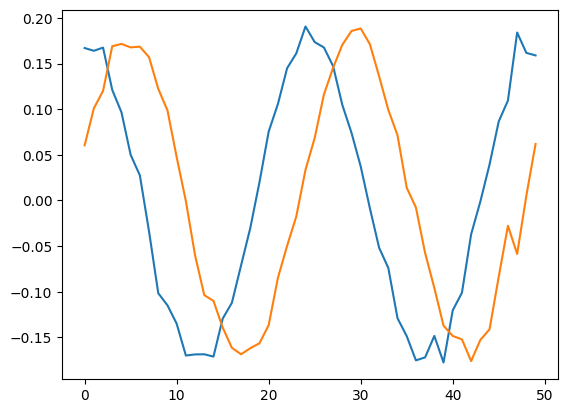

In [11]:
plt.plot(projection[-1,0,:])
plt.plot(projection[-1,1,:])

Text(0.5, 1.0, 'pca 0.48')

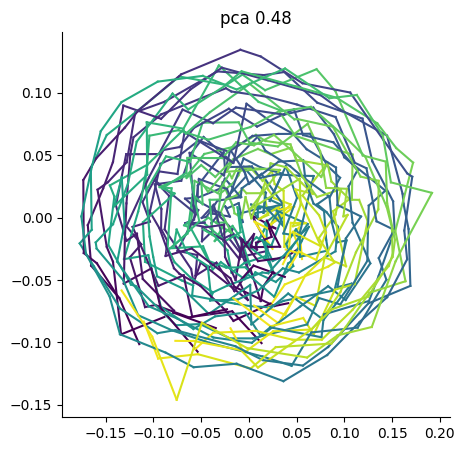

In [12]:
""" PCA """
X_train_pca = np.concatenate(X_train.swapaxes(1,2))
X_test_pca = np.concatenate(X_test.swapaxes(1,2))
full_data_var = np.sum(np.var(X_test, axis=0))

num_pcs = 2
pca = PCA(num_pcs)
Y_pca = pca.fit(X_train_pca).transform(X_test_pca)
PCs = pca.components_
Y_pca = Y_pca.reshape(-1, time_steps, num_pcs).swapaxes(1,2)
pca_variance_captured = pca.explained_variance_ratio_

plot_2D(Y_pca)
plt.title(f"pca {var_explained(X_test, PCs[:2].T):.2f}")




ENDS HERE

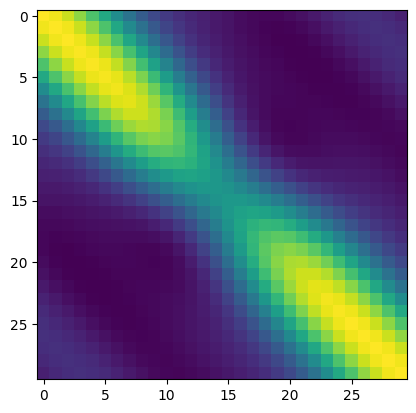

In [40]:
def sample_rff(
    x,
    kernel,
    lengthscale,
    coefficient,
    num_functions,
    num_features,
):
    
    # Dimension of data space
    x_dim = x.shape[-1]
    omega_shape = (num_functions, num_features, x_dim)
    
    # Handle each of three possible kernels separately
    if kernel == 'eq':
        omega = np.random.normal(size=omega_shape)
        
    elif kernel == 'laplace':
        omega =  np.random.standard_cauchy(size=omega_shape)
        
    elif kernel == 'cauchy':
        omega = np.random.laplace(size=omega_shape)
        
    # Scale omegas by lengthscale
    omega = omega / lengthscale
    
    weights = np.random.normal(
        loc=0.,
        scale=1.,
        size=(num_functions, num_features),
    )
    
    phi = np.random.uniform(
        low=0.,
        high=(2 * np.pi),
        size=(num_functions, num_features, 1),
    )
    
    #features = np.cos(np.einsum('sfd, nd -> sfn', omega, x) + phi)
    #features = (2 / num_features) ** 0.5 * features * coefficient

    features = np.einsum('sfd, nd -> sfn', omega, x)
    cos_values = jnp.cos(features)
    sin_values = jnp.sin(features)
    features = jnp.hstack((cos_values, sin_values))  * (1 / jnp.sqrt(num_features)) 
    
    #functions = np.einsum('sf, sfn -> sn', weights, features)
    functions=None
    
    return functions, features

lengthscale = 1.
coefficient = 1.
num_functions = 10
num_features = 50

# Input locations
x = np.linspace(-3., 3., 30)[:, None]

functions, features = sample_rff(x=x,       #features (K, N, T)
        kernel='eq', 
        lengthscale=lengthscale, 
        coefficient=coefficient, 
        num_functions=num_functions, 
        num_features=num_features,
    )

plt.imshow(np.cov(features[1].T))

In [ ]:
def projected_X_linear(X, seed = 42, proj_dims = 10, plot=False):
    key = random.PRNGKey(seed)
    key, subkey = random.split(key)

    #Project X
    proj_matrix = random.normal(key, (proj_dims, X.shape[1]))
    proj_matrix , _ = jnp.linalg.qr(proj_matrix)                    #(N',N)
    X = jnp.einsum('lj,ijk->ilk', proj_matrix, X)                   #(K, N', T)
    
    #Observation noise 
    noise = random.normal(subkey, (X.shape)) 
    X += (noise)  /100
    X = jnp.array(X)

    if plot:
        plt.figure(figsize=(3,3))
        for i,initial_conditions in enumerate(initial_conditions_list):
            plt.plot(X[i,0,:],X[i,10,:] )
    return X

In [ ]:
def rotation_system(t, y):
    x1, x2 = y
    dx1_dt = - 1*x2 
    dx2_dt = 1*x1 
    return [dx1_dt, dx2_dt]

def pendulum_system(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = -np.sin(x1) 
    return [dx1_dt, dx2_dt]

def duffing_oscillator(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = x1 - x1**3 
    return [dx1_dt, dx2_dt]

def van_der_pol(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = (1 - x1**2) * x2 - x1 
    return [dx1_dt, dx2_dt]


t_span = (0, 10)                                    # simulate from t=0 to t=10 seconds
t_eval = np.linspace(t_span[0], t_span[1], 400)     # time points where the solution is computed


num_trajectories = 150

seed = 42
np.random.seed(seed) 
initial_conditions_list = np.random.uniform(low=-np.pi, high=np.pi, size=(num_trajectories, 2))

plt.figure(figsize=(3,3))
for initial_conditions in initial_conditions_list:
    solution = solve_ivp(rotation_system, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]
    plt.plot(x1, x2, label=f'IC: {np.round(initial_conditions, 2)}')

#Create X ( K = initial condition, N = (x1,x2), T = len(t_eval) )
X = np.zeros((num_trajectories, 2, len(t_eval)))
for i, initial_conditions in enumerate(initial_conditions_list):
    solution = solve_ivp(rotation_system, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]

    X[i, 0, :] = x1
    X[i, 1, :] = x2
X = jnp.array(X)                                                                        #(K, N, T)

np.mean(compute_S(X)) #np.mean(compute_S(X, iterations=100))

In [ ]:
# key = random.PRNGKey(0)
# perm_indices = random.permutation(key, len(radii))
# radii = radii[perm_indices]
